*This notebook is adapted from [here](https://github.com/dipanjanS/deep_transfer_learning_nlp_dhs2019/blob/master/notebooks/6%20-%20Transformers%20-%20DistilBERT.ipynb). The purpose of this notebook is to show how to convert a custom DistilBERT-based text classification model to TensorFlow Lite.*

## Initial Setup

In [ ]:
!nvidia-smi

Mon Oct 12 01:43:22 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    39W / 300W |      0MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
!pip install transformers

In [ ]:
import os
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import transformers
import matplotlib.pyplot as plt

%matplotlib inline

# Fix random seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

TF Version:  2.4.0-dev20200810
Eager mode:  True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available


## SST-2 Dataset

In [ ]:
data_dir = tf.keras.utils.get_file(
      fname='SST-2.zip',
      origin='https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2FSST-2.zip?alt=media&token=aabc5f6b-e466-44a2-b9b4-cf6337f84ac8',
      extract=True)
data_dir = os.path.join(os.path.dirname(data_dir), 'SST-2')

In [ ]:
!ls $data_dir

dev.tsv  original  test.tsv  train.tsv


In [ ]:
train = os.path.join(data_dir, "train.tsv")
valid = os.path.join(data_dir, "dev.tsv")
test = os.path.join(data_dir, "test.tsv")

In [ ]:
train_dataset = pd.read_csv(train, sep='\t')
valid_dataset = pd.read_csv(valid, sep='\t')
test_dataset = pd.read_csv(test, sep='\t')

In [ ]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67349 entries, 0 to 67348
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  67349 non-null  object
 1   label     67349 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.0+ MB


In [ ]:
valid_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 872 entries, 0 to 871
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  872 non-null    object
 1   label     872 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 13.8+ KB


In [ ]:
train_dataset.head()

,sentence,label
0,hide new secretions from the parental units,0
1,"contains no wit , only labored gags",0
2,that loves its characters and communicates som...,1
3,remains utterly satisfied to remain the same t...,0
4,on the worst revenge-of-the-nerds clichés the ...,0


In [ ]:
train_reviews = train_dataset['sentence'].values
train_sentiments = train_dataset['label'].values

valid_reviews = valid_dataset['sentence'].values
valid_sentiments = valid_dataset['label'].values

test_reviews = test_dataset['sentence'].values

train_reviews.shape, valid_reviews.shape, test_reviews.shape

((67349,), (872,), (1821,))

## Preprocess Dataset

In [ ]:
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [ ]:
import tqdm

def create_bert_input_features(tokenizer, docs, max_seq_length):
    
    all_ids, all_masks = [], []
    for doc in tqdm.tqdm(docs, desc="Converting docs to features"):
        tokens = tokenizer.tokenize(doc)
        if len(tokens) > max_seq_length-2:
            tokens = tokens[0 : (max_seq_length-2)]
        tokens = ['[CLS]'] + tokens + ['[SEP]']
        ids = tokenizer.convert_tokens_to_ids(tokens)
        masks = [1] * len(ids)
        # Zero-pad up to the sequence length.
        while len(ids) < max_seq_length:
            ids.append(0)
            masks.append(0)
        all_ids.append(ids)
        all_masks.append(masks)
    encoded = np.array([all_ids, all_masks])
    return encoded

## Build the Model

In [ ]:
MAX_SEQ_LENGTH = 128

inp_id = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_input_ids")
inp_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_input_masks")
inputs = [inp_id, inp_mask]

hidden_state = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')(inputs)[0]
pooled_output = hidden_state[:, 0]    
dense1 = tf.keras.layers.Dense(256, activation='relu')(pooled_output)
drop1 = tf.keras.layers.Dropout(0.25)(dense1)
dense2 = tf.keras.layers.Dense(256, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(0.25)(dense2)
output = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)


model = tf.keras.Model(inputs=inputs, outputs=output)
model.compile(optimizer=tf.optimizers.Adam(learning_rate=3e-5), 
              loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_transform', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
bert_input_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
bert_input_masks (InputLayer)   [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB ((None, 128, 768),)  66362880    bert_input_ids[0][0]             
                                                                 bert_input_masks[0][0]           
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 768)          0           tf_distil_bert_model[0

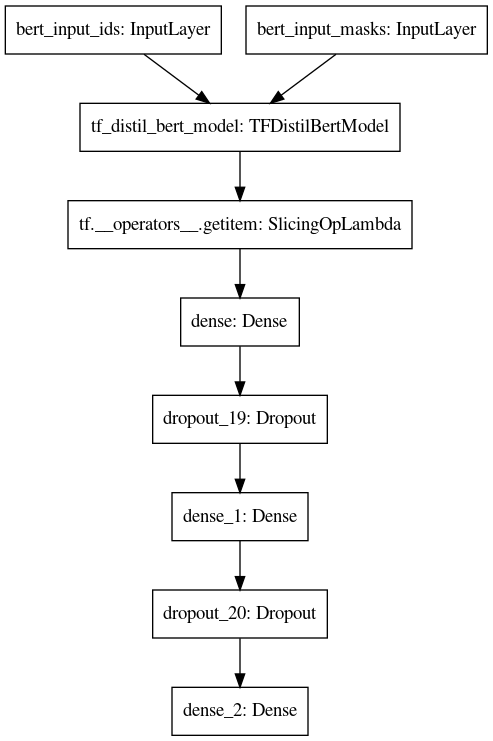

In [ ]:
tf.keras.utils.plot_model(model, "model.png")

## Create TensorFlow Datasets

In [ ]:
train_features_ids, train_features_masks = create_bert_input_features(tokenizer, train_reviews, 
                                                                      max_seq_length=MAX_SEQ_LENGTH)
val_features_ids, val_features_masks = create_bert_input_features(tokenizer, valid_reviews, 
                                                                  max_seq_length=MAX_SEQ_LENGTH)

print('Train Features:', train_features_ids.shape, train_features_masks.shape)
print('Val Features:', val_features_ids.shape, val_features_masks.shape)

Converting docs to features: 100%|██████████| 872/872 [00:00<00:00, 2785.91it/s]

Train Features: (67349, 128) (67349, 128)
Val Features: (872, 128) (872, 128)


In [ ]:
# Create TensorFlow datasets for better performance
train_ds = (
    tf.data.Dataset
    .from_tensor_slices(((train_features_ids, train_features_masks), train_sentiments))
    .shuffle(2048)
    .batch(24)
    .prefetch(tf.data.experimental.AUTOTUNE)
)
    
valid_ds = (
    tf.data.Dataset
    .from_tensor_slices(((val_features_ids, val_features_masks), valid_sentiments))
    .batch(24)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

## Train the Model

In [ ]:
start = time.time()
model.fit(train_ds,
    validation_data=valid_ds,
    epochs=3)
end = time.time()
print("Training took {} seconds.".format(end - start))

Epoch 1/3
2807/2807 [==============================] - 317s 113ms/step - loss: 0.2849 - accuracy: 0.8773 - val_loss: 0.2555 - val_accuracy: 0.8979
Epoch 2/3
2807/2807 [==============================] - 309s 110ms/step - loss: 0.1231 - accuracy: 0.9565 - val_loss: 0.2576 - val_accuracy: 0.9014
Epoch 3/3
2807/2807 [==============================] - 308s 110ms/step - loss: 0.0823 - accuracy: 0.9715 - val_loss: 0.3343 - val_accuracy: 0.9025
Training took 934.4114644527435 seconds.


In [ ]:
model.evaluate(valid_ds)[1]

37/37 [==============================] - 1s 40ms/step - loss: 0.3343 - accuracy: 0.9025


0.9025229215621948

In [ ]:
model.save_weights('distillbert_ft_wts.h5')

## Model Conversion with TensorFlow Lite

Dynamic-range quantization is referred from [Hugging Face's official script](https://github.com/huggingface/tflite-android-transformers/blob/master/models_generation/distilbert.py).

### Dynamic-range

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, 
                                       tf.lite.OpsSet.SELECT_TF_OPS]
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
open("distilbert_sst_seq_128.tflite", "wb").write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmp4x_zcb2m/assets


INFO:absl:Using new converter: If you encounter a problem please file a bug. You can opt-out by setting experimental_new_converter=False


66977584

In [ ]:
!ls -lh distilbert_sst_seq_128.tflite

-rw-r--r-- 1 jupyter jupyter 64M Oct 12 02:00 distilbert_sst_seq_128.tflite


### Float16

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, 
                                       tf.lite.OpsSet.SELECT_TF_OPS]
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert()
open("distilbert_sst_seq_128_fp16.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp8kp80euc/assets


INFO:tensorflow:Assets written to: /tmp/tmp8kp80euc/assets
INFO:absl:Using new converter: If you encounter a problem please file a bug. You can opt-out by setting experimental_new_converter=False


132845872

In [ ]:
!ls -lh distilbert_sst_seq_128_fp16.tflite

-rw-r--r-- 1 jupyter jupyter 127M Oct 12 02:01 distilbert_sst_seq_128_fp16.tflite


### Integer

In [ ]:
# # ==============Representative dataset====================
# train_features_ids = train_features_ids.astype(np.int32)
# train_features_masks = train_features_masks.astype(np.int32)
# train_tf_dataset = tf.data.Dataset.from_tensor_slices((train_features_ids, 
#     train_features_masks))

# def representative_dataset_gen():
#     for feature_id, feature_mask in train_tf_dataset.take(10):
#         yield [feature_id, feature_mask]

# # ==============Conversion====================
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, 
#                                        tf.lite.OpsSet.SELECT_TF_OPS]
# converter.representative_dataset = representative_dataset_gen
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# tflite_model = converter.convert()
# open("distilbert_sst_seq_128_int.tflite", "wb").write(tflite_model)

***Integer quantization isn't currently supported for this model.*** [Here](https://github.com/sayakpaul/BERT-for-Mobile/blob/master/Evaluation_SST_2_DistilBERT.ipynb) you can find the evaluation notebook. 